In [2]:
! pip install pyro-ppl
import pyro
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyro.distributions import Normal, Bernoulli
from pyro.infer import Importance, EmpiricalMarginal
from pyro.infer.util import torch_item

   ---------------------------------------- 745.2/745.2 kB 1.3 MB/s eta 0:00:00


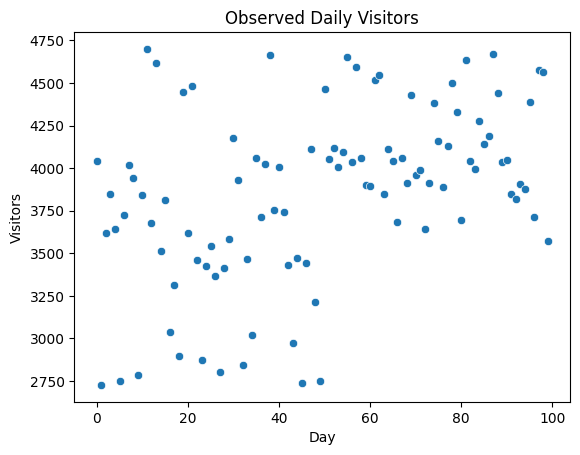

Estimated Campaign Effect: -22.08362579345703
Estimated Weather Effect: 11.26152229309082


In [4]:
# 生成示例数据集
np.random.seed(42)
n_days = 100
marketing_campaign = np.random.choice(['A', 'B'], size=n_days)
weather = np.random.choice(['sunny', 'rainy', 'cloudy'], size=n_days)
visitors = np.random.randint(1000, 5000, size=n_days)
conversion_rate = np.random.uniform(0.02, 0.05, size=n_days)

# 引入因果关系，例如，假设某个营销活动在第50天开始
marketing_campaign[50:] = 'A'

# 模拟日活率增加的因果机制
def causal_mechanism(marketing_campaign, weather):
    base_rate = 3000  # 基础日活率
    campaign_effect = 1000 if marketing_campaign == 'A' else 0  # 营销活动的影响
    weather_effect = {'sunny': 500, 'rainy': -200, 'cloudy': 0}[weather]  # 天气的影响
    return base_rate + campaign_effect + weather_effect

# 生成观测数据
observed_visitors = []
for i in range(n_days):
    observed_visitors.append(causal_mechanism(marketing_campaign[i], weather[i]) + np.random.normal(scale=100))
observed_visitors = np.array(observed_visitors)

# 绘制示例数据
sns.scatterplot(x=np.arange(n_days), y=observed_visitors)
plt.xlabel('Day')
plt.ylabel('Visitors')
plt.title('Observed Daily Visitors')
plt.show()

# 定义因果模型
def model(marketing_campaign, weather, observed_visitors=None):
    campaign_effect = pyro.sample("campaign_effect", Normal(0, 500))
    weather_effect = pyro.sample("weather_effect", Normal(0, 500))
    base_rate = pyro.sample("base_rate", Normal(3000, 500))
    predicted_visitors = base_rate + campaign_effect * (marketing_campaign == 'A') + weather_effect * (weather == 'sunny')
    with pyro.plate("observe_data"):
        pyro.sample("observed_visitors", Normal(predicted_visitors, 100), obs=observed_visitors)

# 进行推断
conditioned_model = pyro.condition(model, data={"observed_visitors": torch.tensor(observed_visitors)})
# approximate the posterior distribution of the model's parameters (campaign effect, weather effect, base rate) given the observed data. 
# This is a way to infer the effects of the marketing campaign and weather on visitor numbers from the observed data.
posterior = Importance(conditioned_model, num_samples=1000).run(marketing_campaign, weather)

# 获取因果效应的后验分布
campaign_effect_samples = EmpiricalMarginal(posterior, "campaign_effect").enumerate_support()
weather_effect_samples = EmpiricalMarginal(posterior, "weather_effect").enumerate_support()

# 打印因果效应的估计值
campaign_effect_mean = torch.mean(campaign_effect_samples)
weather_effect_mean = torch.mean(weather_effect_samples)
print("Estimated Campaign Effect:", torch_item(campaign_effect_mean))
print("Estimated Weather Effect:", torch_item(weather_effect_mean))

Estimated Campaign Effect: -22.08362579345703

This value suggests that, on average, the presence of campaign 'A' is associated with a decrease of approximately 22 visitors per day compared to the baseline (which could be when there is no campaign or when campaign 'B' is active). This is counterintuitive given the designed causal mechanism where campaign 'A' was supposed to add 1000 visitors, so this could be a sign that the model or the data is not correctly capturing the actual causal effect.  

Estimated Weather Effect: 11.26152229309082

This value suggests that, on average, sunny weather is associated with an increase of approximately 11 visitors per day compared to non-sunny days (rainy or cloudy). This effect size is much smaller than expected based on the causal mechanism you defined (which adds 500 visitors on sunny days).